## Problem Statement
## Table of Contents:
* [Section 1: User Defined Functions](#udf)
* [Section 2: Exploratory Data Analysis](#eda)
* [Section 3: Derived Variables](#derived-variables)
* [Section 4: Data Normalization](#data-normalization)
* [Section 5: Building the model](#model-building)
* [Model Version 1](#model-v1)
* [Model Version 1: Summary](#model-v1-summary)
* [Model Version 2](#model-v2)
* [Model Version 2: Summary](#model-v2-summary)
* [Model Version 3](#model-v3)
* [Model Version 3: Summary](#model-v3-summary)
* [Model Version 4](#model-v4)
* [Model Version 4: Summary](#model-v4-summary)
* [Model Version 5](#model-v5)
* [Model Version 5: Summary](#model-v5-summary)
* [Model Version 6](#model-v6)
* [Model Version 6: Summary](#model-v6-summary)
* [Linear Regression using SkLearn](#lr)
* [Using SkLearn RFE to compute model and compare](#rfe)
* [Final Summary and Recommendations](#summary)

In [595]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit


In [479]:
df = pd.read_csv('CarPrice_Assignment.csv')

## Section 1: User Defined Functions <a class="anchor" id="udf"></a>


In [1]:
# User defined functions

def do_analysis_numeric(df, column_name):

    df[[column_name]].plot(kind='box')
    df[[column_name, 'price']].plot(kind='scatter', x=column_name, y='price', legend=True)
        
    print(df[[column_name, 'price']].corr())

        
def do_analysis_categorical(df, column_name):
    print(df[column_name].value_counts())
    df[['price', column_name]].groupby(column_name).mean().plot(kind='bar')
    
#Print the model summary with is basically the Ordinary Least Squares model summary
# Prints the Rsquared, Adjusted RSquared, p value and the variable coefficients.
def get_model_summary(X, y):
    model = sm.OLS(y.values, X.values)
    res = model.fit()
    print(res.summary())
    return res

# Get the Variance Influence Factor for the given training data
def get_VIF(X):
    vif = pd.DataFrame()
    vif["feature name"] = X.columns
    vif["Variance Influence Factor (VIF)"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif)
    
def print_error_terms(y, ypred, number_of_variables):
    mse = mean_squared_error(y, ypred)
    r_squared = r2_score(y, ypred)
    
    # Compute the adjusted rsquared
    n = y.shape[0]
    adjusted_r_squared = 1-(1-r_squared)*(n-1)/(n-number_of_variables-1)
    print("Mean Squared Error: ", mse)
    print("R Squared: ", r_squared)
    print("Adjusted R Squared: ", adjusted_r_squared)
    
    
def plot_actual_vs_predicted(y, ypred):
    c = [i for i in range(0,y.shape[0],1)]
    fig = plt.figure()
    plt.plot(c, y, color="blue", linewidth=2.5, linestyle="-")
    plt.plot(c, ypred, color="red",  linewidth=2.5, linestyle="-")
    fig.suptitle('Actual and Predicted Car Price', fontsize=20)
    plt.xlabel('Index', fontsize=18)
    plt.ylabel('Car Price', fontsize=16) 
    
# plot the error terms and the error histogram
def plot_error(y, ypred):
    (y - ypred).plot(kind='hist')

In [481]:
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [482]:
# See all the column names in the dataset
df.columns

Index(['car_ID', 'symboling', 'CarName', 'fueltype', 'aspiration',
       'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype',
       'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'price'],
      dtype='object')

In [483]:
#Check the size of the data
df.shape

(205, 26)

## Exploratory Data Analysis <a class="anchor" id="eda"></a>


 0    67
 1    54
 2    32
 3    27
-1    22
-2     3
Name: symboling, dtype: int64


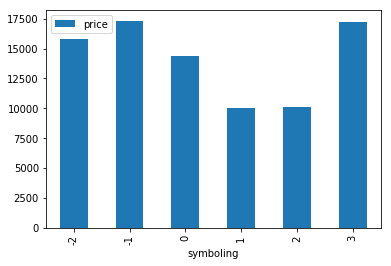

In [484]:
do_analysis_categorical(df,'symboling')

           wheelbase     price
wheelbase   1.000000  0.577816
price       0.577816  1.000000


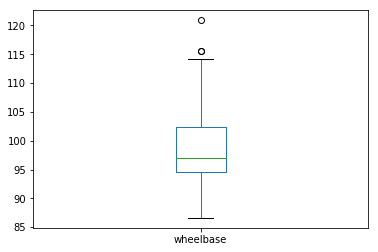

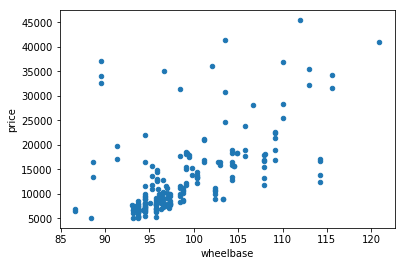

In [500]:
do_analysis_numeric(df,'wheelbase')
# There is no strong corelation between the wheelbase and the price.
# The scatterplot is also not showing a linear trend. There is a lot of error term.

## Based on the analysis about, we can categorise the variables into the following.<BR> We will build a model adding one variable at a time, and checking the performance of the model each time we add.
## Variables that show significant corelation :


## Variables that show slight corelation :


## Check which variables can interact or are multicolinear :


## Derived variables:


In [516]:
# First we will encode all the categorical variables.
df = pd.get_dummies(df, columns = ['LuxuryBrand','symboling', 'fueltype', 'aspiration', 'carbody', 'drivewheel', 'enginelocation',
                             'enginetype', 'cylindernumber', 'fuelsystem', 'doornumber'], drop_first = True)

In [517]:
df.columns

Index(['car_ID', 'wheelbase', 'carlength', 'carwidth', 'carheight',
       'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio',
       'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price', 'CarBrand',
       'LuxuryBrand_1', 'symboling_-1', 'symboling_0', 'symboling_1',
       'symboling_2', 'symboling_3', 'fueltype_gas', 'aspiration_turbo',
       'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'drivewheel_fwd', 'drivewheel_rwd',
       'enginelocation_rear', 'enginetype_dohcv', 'enginetype_l',
       'enginetype_ohc', 'enginetype_ohcf', 'enginetype_ohcv',
       'enginetype_rotor', 'cylindernumber_five', 'cylindernumber_four',
       'cylindernumber_six', 'cylindernumber_three', 'cylindernumber_twelve',
       'cylindernumber_two', 'fuelsystem_2bbl', 'fuelsystem_4bbl',
       'fuelsystem_idi', 'fuelsystem_mfi', 'fuelsystem_mpfi',
       'fuelsystem_spdi', 'fuelsystem_spfi', 'doornumber_two'],
      dtype='object')

## Section 4: Data Normalization <a class="anchor" id="data-normalization" />


In [518]:
original_dataframe = df

# We will scale the variables
# First we will save a dataframe with the variables that dont need to be scaled to concat later
df_no_scaling = df[['car_ID','CarBrand', 'price']]

scaler = MinMaxScaler()
df_to_scale = df.drop(['car_ID','CarBrand', 'price'], axis = 1)
columns_to_retain = df_to_scale.columns
scaled_array = scaler.fit_transform(df_to_scale)

# Regenerate the dataframe
scaled_df = pd.DataFrame(data = scaled_array, columns = columns_to_retain)

# Now concatenate the non scaled columns with the scaled columns
df = pd.concat([scaled_df, df_no_scaling], axis = 1)

In [586]:
#Check if the mean of one of the variables is under 1. To verify if scaling has happened.
df.curbweight.mean()

0.41410622717553786

## Model Version 1 <a class="anchor" id="model-v1" />
<br>---------------------------------------------------------------------------
<br>We will build a model with 2 initial features - LuxuryBrand and Curbweight.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     1721.
Date:                Fri, 17 Aug 2018   Prob (F-statistic):          5.02e-128
Time:                        08:30:59   Log-Likelihood:                -1972.6
No. Observations:                 205   AIC:                             3949.
Df Residuals:                     203   BIC:                             3956.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          6505.7696    688.507      9.449      0.0

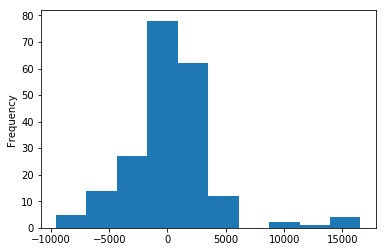

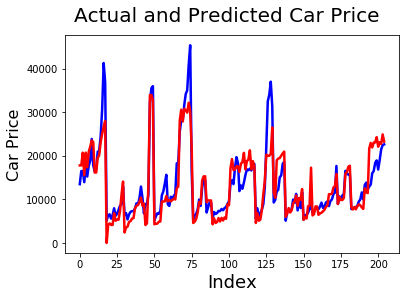

In [520]:
X = df[['LuxuryBrand_1', 'curbweight']]
y = df['price']
model = get_model_summary(X, y)
ypred = model.predict(X)
print_error_terms(y, ypred, X.shape[1])
plot_error(y, ypred)
plot_actual_vs_predicted(y, ypred)


In [521]:
get_VIF(X)

    feature name  Variance Influence Factor (VIF)
0  LuxuryBrand_1                         1.827799
1     curbweight                         1.827799


## Model Version 1 : Summary <a class="anchor" id="model-v1-summary" />
<br/>
<table align=left>
    <tr>
        <td><b>R squared</b></td>
        <td>0.72</td>
    </tr>
    <tr>
        <td><b>Adjusted R squared</b></td>
        <td>0.72</td>
    </tr>
    <tr>
        <td> <b>Max VIF </b></td>
        <td> 1.54 </td>
    </tr>
    <tr>
        <td> <b> Features </b> </td>
        <td> LuxuryBrand_1, curbweight</td>
    </tr>
</table>
    
            

## Linear Regression using SkLearn <a class="anchor" id="lr" />

In [567]:
# Use Sklearn to build the final model. - done
# TODO. Try the Sklear RFE and see what it outputs.
# Write the summary of the model weights and the recommendation.

In [572]:
X = df[['LuxuryBrand_1', 'enginesize','cylindernumber_two', 'drivewheel_fwd', 'enginelocation_rear']]
y = df['price']

lr = LinearRegression()
lr.fit(X, y)

ypred = lr.predict(X)

In [571]:
print("Coefficients", lr.coef_)

Coefficients [ 5951.36272148 33003.16306783  7510.04548582 -1334.92273212
  7935.04384833]


In [573]:
print_error_terms(y, ypred, X.shape[1])

Mean Squared Error:  6597393.118596114
R Squared:  0.8961211173590331
Adjusted R Squared:  0.8935110951821243


## Using SkLearn.RFE to automatically compute a model <a class="anchor" id="rfe" />

In [588]:
X = df.drop(['car_ID','CarBrand', 'price'], axis = 1)
y = df['price']
lr = LinearRegression()
selector = RFE(lr, n_features_to_select=5)
selector.fit(X, y)


RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
  n_features_to_select=5, step=1, verbose=0)

In [589]:
selector.ranking_

array([21,  9,  1, 39,  6,  1, 32, 12,  1, 15, 13, 35, 27,  2, 18, 14, 16,
       17, 19,  1, 36, 23, 22, 25, 24, 40, 34,  1, 10, 33, 20, 31, 11, 38,
        4,  5,  7, 26,  8, 43, 41, 28,  3, 29, 42, 30, 37, 44])

In [590]:
selector.support_


array([False, False,  True, False, False,  True, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [585]:
X.columns

Index(['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg', 'LuxuryBrand_1', 'symboling_-1',
       'symboling_0', 'symboling_1', 'symboling_2', 'symboling_3',
       'fueltype_gas', 'aspiration_turbo', 'carbody_hardtop',
       'carbody_hatchback', 'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd',
       'drivewheel_rwd', 'enginelocation_rear', 'enginetype_dohcv',
       'enginetype_l', 'enginetype_ohc', 'enginetype_ohcf', 'enginetype_ohcv',
       'enginetype_rotor', 'cylindernumber_five', 'cylindernumber_four',
       'cylindernumber_six', 'cylindernumber_three', 'cylindernumber_twelve',
       'cylindernumber_two', 'fuelsystem_2bbl', 'fuelsystem_4bbl',
       'fuelsystem_idi', 'fuelsystem_mfi', 'fuelsystem_mpfi',
       'fuelsystem_spdi', 'fuelsystem_spfi', 'doornumber_two'],
      dtype='object')

SkLearn Automatic Recursive Feature Elimination has suggested - [1- carwidth, 1- enginesize, 1- compressionratio, 2-fueltype_gas and 1-enginelocation_rear] <br>
Manually created model has the following features: LuxuryBrand_1, enginesize, cylindernumber_two, drivewheel_fwd, enginelocation_rear <br>
The common features are enginesize and enginelocation_rear

## Final Summary and Recommendations <a class="anchor" id="summary" />